# Perform frequency-differencing and masking to compute NASC attributed to krill from ship echosounder data

Jupyter notebook accompanying the manuscript:

_Echopype: Interoperable and scalable echosounder data processing with Echopype_   
_Authors: Wu-Jung Lee, Landung Setiawan, Caesar Tuguinay, Emilio Mayorga, and Valentina Staneva_

## Introduction

### Description

This notebook uses a 2-day subset of the EK60 echosounder data collected during the [2017 Joint U.S.-Canada Integrated Ecosystem and Pacific Hake Acoustic Trawl Survey (aka the "Hake survey")](https://www.fisheries.noaa.gov/west-coast/science-data/joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey) to illustrate a processing workflow to compute Nautical Areal Scattering Coefficient (NASC) attributed to krill. The workflow includes steps to perform data conversion, calibration, regridding, and frequency differencing, using functions from [`Echopype`](https://echopype.readthedocs.io) and core scientific Python software packages, particularly `NumPy`, `Xarray`, and `Dask`.

### Outline

1) [Convert EK60 `.raw` files to EchoData objects](###Convert-EK60-.raw-files-to-EchoData-objects)
2) [Combine EchoData objects](###Combine-EchoData-objects)
3) [Calibrate raw backscatter measurement in the combined EchoData object to Sv](###Calibrate-raw-backscatter-measurement-in-the-combined-EchoData-object-to-Sv)
4) [Regrid calibrated Sv data to MVBS](###Regrid-calibrated-Sv-data-to-MVBS)
5) [Generate and apply a frequency-differencing mask for krill on the echogram](###Generate-and-apply-a-frequency-differencing-mask-for-krill-on-the-echogram)
6) [Compute water column-integrated NASC for krill](###Compute-water-column-integrated-NASC-for-krill)
7) [Plot water column-integrated krill NASC on a map](###Plot-water-column-integrated-krill-NASC-on-a-map)

### Running the notebook

This notebook can be run with a conda environment created using the [conda environment file](../conda/environment-ep-main.yml). The notebook creates a directory, if not already present: `./exports/krill_freq_diff`. All Zarr files will be exported there.

### Note
We encourage importing Echopype as `ep` for consistency.

In [1]:
from pathlib import Path

import fsspec
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from dask.distributed import Client

import echopype as ep
from echopype import colormap # needed for the EK500 colormap

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
# Ignore large graph dask UserWarnings
warnings.simplefilter("ignore", category=UserWarning)

### Path setup

Create directories to store Zarr files:

In [2]:
base_path = Path("./exports/krill_freq_diff")
base_path.mkdir(exist_ok=True, parents=True)

echodata_zarr_path = base_path / "echodata_zarr"
echodata_zarr_path.mkdir(exist_ok=True)
combined_zarr_path = base_path / "combined_zarr"
combined_zarr_path.mkdir(exist_ok=True)

### Dask Client setup

Echopype leverages Dask's lazy-load mechanisms to perform distributed computation on large datasets. We use the Dask `Client` that is pointed to a `Scheduler` that schedules tasks and allocate memory for these computations.

Due to the large volumes of data (if you did not subselect files above), if you have enough memory resources, set the `n_workers` to be such that each worker has at least 4 GB of memory.

In [3]:
# Use maximum number of CPUs for Dask Client
client = Client() # Set n_workers so that total_RAM / n_workers >= 4
                  # or leave empty and let Dask decide
print("Dask Client Dashboard:", client.dashboard_link)

Dask Client Dashboard: http://127.0.0.1:8787/status


Click on the Dask Client Dashboard link above to view the computations live.

For more information on how to use, view, and interpret the Dashboard, go to this link: https://docs.dask.org/en/stable/dashboard.html

### Identify target echosounder data files

Here, we access the public [NOAA Water-Column Sonar Data Archive S3 bucket](https://registry.opendata.aws/ncei-wcsd-archive/) via the [fsspec](https://filesystem-spec.readthedocs.io) file system interface, to identify a list of EK60 `.raw` files to be processed in this notebook.

In [4]:
# Setup filesystem
fs = fsspec.filesystem('s3', anon=True)
bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60"

# Select all RAW files from July 2017
s3rawfiles = fs.glob(f"{bucket}/{rawdirpath}/*.raw")
select_files = [
    s3path
    for s3path in s3rawfiles
    if any(
        f"D2017{datestr}" in s3path
        for datestr in ["0728", "0729"]
    )
]
print(f"There are {len(select_files)} target raw files available")

There are 170 target raw files available


These RAW files combined are about 4 GB in size.

**NOTE:**

If you are on Binder or are running this on a machine with less than 15 GB of RAM, we recommend you to use only a subset of the `select_files`.

In [5]:
# Uncomment the line below to use a subset of the 170 files

# select_files = select_files[0:10]

## Data processing workflow

The following data processing steps follow the typical Echopype workflow, which converts and standardizes data before performing more computation. Below we first convert and save the `.raw` files generated by EK60 to Zarr stores on disk, and lazy-load them back for downstream processing. This allows us to perform computations that may require resources that are larger than the local system memory.

More information on lazy loading can be found [here](https://en.wikipedia.org/wiki/Lazy_loading).

#### Reference compute runtimes for machines of two difference sizes

We tested the compute runtimes of the computationally intensive Echopype functions run on this notebook on a moderately sized virtual machine (VM) with similar specs to a work laptop, and a large data center VM.

##### 4 CPU 15 GB RAM VM
- Converting `.raw` files with `ep.open_raw`: **3min 1secs**
- Combining EchoData objects with `ep.combine_echodata`: **4min 54secs**
- Calibrating raw backscatter data with `ep.calibrate.compute_Sv`: **59secs**
- Regridding with `ep.commongrid.compute_MVBS`: **2min 22secs**

##### 64 CPU 250 GB RAM VM
- Converting `.raw` files with `ep.open_raw`: **44secs**
- Combining EchoData objects with `ep.combine_echodata`: **4min 15secs**
- Calibration raw backscatter data with `ep.calibrate.compute_Sv`: **17secs**
- Regridding Sv Data with `ep.commongrid.compute_MVBS`: **43secs**

The virtual machines were provided by [Jetstream2](https://jetstream-cloud.org/index.html).

### Convert EK60 `.raw` files to EchoData objects

In [6]:
%%time

# Save EchoData objects locally
def open_and_save(raw_file, sonar_model, use_swap, save_path, storage_options):
    try:
        ed = ep.open_raw(
            raw_file=f's3://{raw_file}',
            sonar_model=sonar_model,
            use_swap=use_swap,
            storage_options=storage_options,
        )
        ed.to_zarr(save_path, overwrite=True, compute=True)
    except Exception as e:
        print("Error with Exception: ", e)

# Parse EK60 `.RAW` file and save to Zarr Store
open_and_save_futures = []
for raw_file_url in select_files:
    open_and_save_future = client.submit(
        open_and_save,
        raw_file=raw_file_url,
        sonar_model='ek60',
        use_swap=True,
        save_path=echodata_zarr_path,
        storage_options={'anon': True}
    )
    open_and_save_futures.append(open_and_save_future)
open_and_save_futures = client.gather(open_and_save_futures)

CPU times: user 13.1 s, sys: 2.03 s, total: 15.1 s
Wall time: 44.4 s


### Combine EchoData objects

Under the hood of the `ep.combine_echodata` function, the Zarr stores of each EchoData object are loaded and appended lazily, meaning that no data loading or appending actually happens until the combined object is saved to disk via `to_zarr`. Since the EchoData is appended sequentially based on the data time sequence and therefore not parallelized, this is the slowest stage of the processing pipeline.

In [7]:
%%time

# Open (lazy-load) Zarr stores containing EchoData Objects, and lazily combine them
ed_future_list = []
for converted_file in sorted(echodata_zarr_path.glob("*.zarr")):
    ed_future = client.submit(    
        ep.open_converted,
        converted_raw_path=converted_file,
        chunks={}
    )
    ed_future_list.append(ed_future)
ed_list = client.gather(ed_future_list)
ed_combined = ep.combine_echodata(ed_list)

# Save the combined EchoData object to a new Zarr store
# The appending operation only happens when relevant data needs to be save to disk
ed_combined.to_zarr(
    combined_zarr_path / "ed_combined.zarr",
    overwrite=True,
    compute=True,
)

# Lazy-load the comined Zarr store
ed_combined = ep.open_converted(
    combined_zarr_path / "ed_combined.zarr",
    chunks={},
)

/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/xarray/core/dataset.py:2549: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]
/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


CPU times: user 3min 6s, sys: 13.1 s, total: 3min 19s
Wall time: 4min 15s


### Calibrate raw backscatter measurement in the combined EchoData object to Sv

Compute Volume Backscattering Strength (Sv) from raw backscatter measurements stored in the converted EchoData object, and add depth and latitude/longitude to this Xarray Dataset.

In [8]:
%%time

# Chunk Echodata Object ping-wise
ed_combined = ed_combined.chunk({"ping_time": 1000, "range_sample": -1})

# Compute Sv
ds_Sv = ep.calibrate.compute_Sv(ed_combined)

# Add Depth
ds_Sv = ep.consolidate.add_depth(ds_Sv, depth_offset=9.15)

# Add Latitude and Longitude
ds_Sv = ep.consolidate.add_location(ds_Sv, ed_combined)

# Save to Zarr and offload computation to disk
ds_Sv.to_zarr(
    combined_zarr_path / "ds_Sv.zarr",
    mode="w",
    compute=True,
)

# Lazy-load the Zarr store
ds_Sv = xr.open_dataset(
    combined_zarr_path / "ds_Sv.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 14 s, sys: 921 ms, total: 14.9 s
Wall time: 17.8 s


### Regrid calibrated Sv data to MVBS

Compute Mean Volume Backscattering Strength (MVBS), which are binned averages of Sv (in the linear domain) across ping time and depth. This gets the data onto a common grid from the original ping times and depth sample size that may vary across ping and channel depending on the echosounder setting.

In [9]:
%%time

# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="depth",
    range_bin='5m', # in meters
    ping_time_bin='20s', # in seconds
)

# Save to Zarr and offload computation to disk
ds_MVBS.to_zarr(
    combined_zarr_path / "ds_MVBS.zarr",
    mode="w",
    compute=True,
)

# Lazy-load the Zarr store
ds_MVBS = xr.open_dataset(
    combined_zarr_path / "ds_MVBS.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 19.1 s, sys: 1.88 s, total: 21 s
Wall time: 43.6 s


### Generate and apply a frequency-differencing mask for krill on the echogram

Frequency-differencing uses echo strength variation across frequency to classify the scatterers. The threshold of the difference of echo strength between observations from a pair of frequencies can be derived empirically or semi-empirically based on physics-based scattering models.

Here we use the thresholds from Phillips et al. (2022) to identify krill:
$$
16.2 \, \textrm{dB} \geq \textrm{MVBS}_\textrm{120kHz} - \textrm{MVBS}_\textrm{38kHz} \geq 10.0 \, \textrm{dB}
$$

**Reference:**

    Phillips EM, Chu D, Gauthier S, Parker-Stetter SL, Shelton AO, Thomas RE. (2022).
    Spatiotemporal variability of euphausiids in the California Current Ecosystem: insights from a recently developed time series. 
    ICES Journal of Marine Science, 79(4): 1312–1326.
    https://doi.org/10.1093/icesjms/fsac055

First, we want to select the upper portion (50m-250m) of the water-column, since that is where we expect zooplankton to be:

In [10]:
ds_upper_water_column_MVBS = ds_MVBS.sel(depth=slice(50, 300)).copy()

Typically the data is also thresholded to ensure that the frequency-differencing is applied on echogram pixels with reasonably high echo strength.

In [11]:
%%time

# MVBS threshold in dB
th_MVBS = -70

# Create copy of MVBS
ds_non_empty_MVBS = ds_upper_water_column_MVBS.copy()

# Replace all Sv less -70 dB with NaN
ds_non_empty_MVBS["Sv"] = xr.where(
    ds_upper_water_column_MVBS["Sv"] < th_MVBS,
    np.nan,
    ds_upper_water_column_MVBS["Sv"]
)

CPU times: user 5.99 ms, sys: 0 ns, total: 5.99 ms
Wall time: 5.81 ms


And then we use the Echopype functions to generate and apply masks to isolate krill on the echogram:

In [12]:
%%time

# Compute compute both frequency differencing inequalities as separate masks
freq_diff_mask_1 = ep.mask.frequency_differencing(
    ds_non_empty_MVBS,
    freqABEq="120 kHz - 38 kHz < 16.2 dB"
)
freq_diff_mask_2 = ep.mask.frequency_differencing(
    ds_non_empty_MVBS,
    freqABEq="120 kHz - 38 kHz > 10.0 dB"
)

# Apply both frequency differencing masks
ds_freq_diff_MVBS = ep.mask.apply_mask(
    ds_non_empty_MVBS,
    [freq_diff_mask_1, freq_diff_mask_2]
)

CPU times: user 442 ms, sys: 49.1 ms, total: 492 ms
Wall time: 1.01 s


#### Plot subset of MVBS and MVBS with frequency differencing mask applied

In [13]:
# Find the 120 kHz channel
ch_sel = [True if "120" in ch_id else False for ch_id in ds_Sv["channel"].values]

Since it's too much to plot the entire MVBS, let's plot a portion of the 120 kHz channel where there are many (suspected) krill:

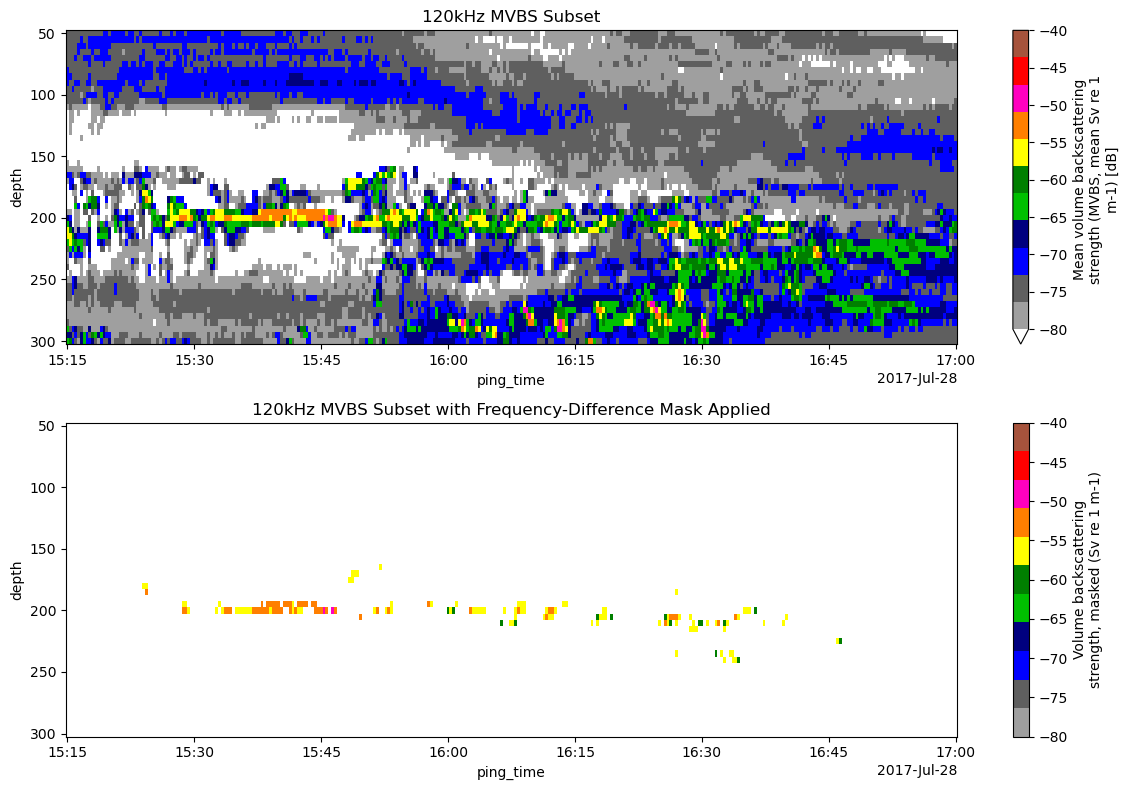

CPU times: user 639 ms, sys: 113 ms, total: 752 ms
Wall time: 879 ms


In [14]:
%%time

# Create subplots with two rows and one column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 120kHz MVBS
pcolormesh1 = ds_upper_water_column_MVBS["Sv"].isel(channel=ch_sel).sel(
    ping_time=slice("2017-07-28T15:15:00.000000000", "2017-07-28T17:00:00.000000000")
).plot(
    ax=ax1,
    y="depth",
    yincrease=False,
    vmax=-40,
    vmin=-80,
    cmap="ep.ek500",
)
ax1.set_title('120kHz MVBS Subset')

# Plot 120kHz MVBS with frequency-difference mask applied
pcolormesh2 = ds_freq_diff_MVBS["Sv"].isel(channel=ch_sel).sel(
    ping_time=slice("2017-07-28T15:15:00.000000000", "2017-07-28T17:00:00.000000000")
).plot(
    ax=ax2,
    y="depth",
    yincrease=False,
    vmax=-40,
    vmin=-80,
    cmap="ep.ek500",
)
ax2.set_title('120kHz MVBS Subset with Frequency-Difference Mask Applied')

# Show plot
plt.tight_layout()
plt.show()

### Compute water column-integrated NASC for krill

NASC is typically computed along regular distance "intervals" and depth "layers." Here, we use an interval of 0.5 nmi and a layer thickness of 10 m, and integrate the NASC values for the 50m-250m portion of the water column.

In [15]:
%%time

# Compute NASC
ds_NASC = ep.commongrid.compute_NASC(
    # Grab only the first 250m in the MVBS
    ds_freq_diff_MVBS,
    range_bin="10 m",
    dist_bin="0.5 nmi"
)

CPU times: user 1.73 s, sys: 126 ms, total: 1.86 s
Wall time: 2.12 s


In [16]:
# Integrate NASC at 120 kHz
ds_NASC_int_120kHz = ds_NASC.copy()
ds_NASC_int_120kHz["NASC"] = (
    ds_NASC["NASC"].isel(channel=ch_sel).squeeze().drop("channel").sum(dim="depth") * 10
)


In [17]:
# Add attributes for automatic xarray plotting
ds_NASC_int_120kHz["NASC"].attrs = {
    "long_name": "Nautical Areal Scattering Coefficient (NASC)",
    "units": "m2 nmi-2"
}


### Plot water column-integrated krill NASC on a map

For plotting, let's plot the NASC values in the log domain so that we can see both the high and low values easily.

In [18]:
%%time

# Log-transform NASC values
ds_NASC_int_120kHz["NASC_log"] = 10 * np.log10(ds_NASC_int_120kHz["NASC"]).compute()
ds_NASC_int_120kHz["NASC_log"].attrs = {
    "long_name": "Log of NASC",
    "units": "m2 nmi-2"
}

CPU times: user 72.4 ms, sys: 40.3 ms, total: 113 ms
Wall time: 241 ms


/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


In the visualization below, the empty water columns (encoded as `NaN` in the NASC dataset) will be drawn with a translucent circle, and we use a dB scale to visualize the wide range of values in NASC:

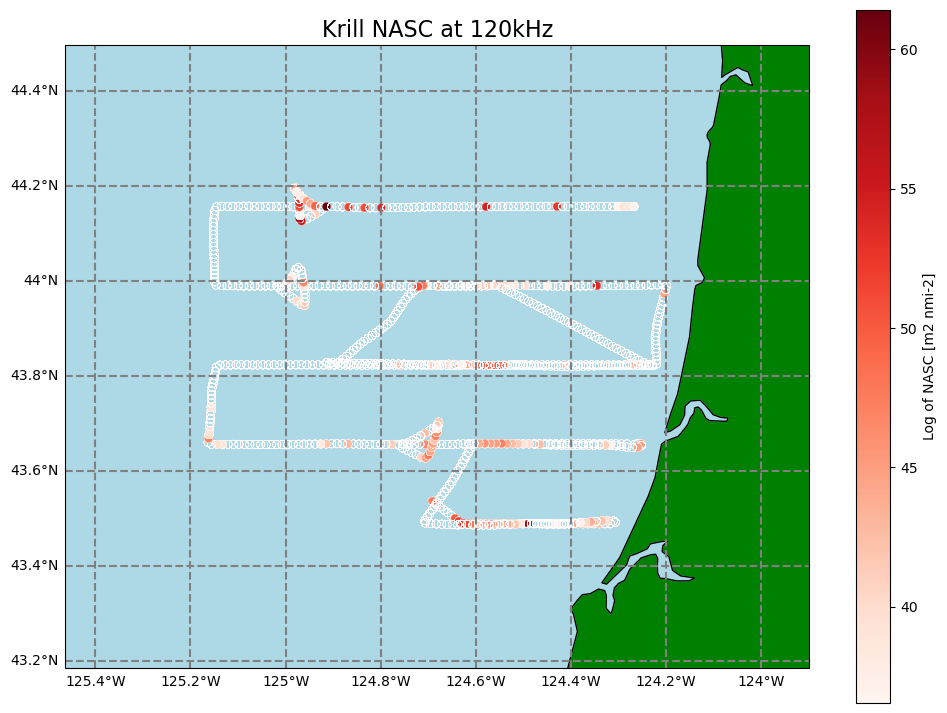

CPU times: user 7.87 s, sys: 1.11 s, total: 8.98 s
Wall time: 8.11 s


In [19]:
%%time

# Create plot
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and gridlines
ax.coastlines()
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1.5,
    color='gray',
    linestyle='--'
)
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False

# Set lat lon extent
ax.set_extent([
    ds_NASC_int_120kHz["longitude"].min().values - 0.3,
    ds_NASC_int_120kHz["longitude"].max().values + 0.3,
    ds_NASC_int_120kHz["latitude"].min().values - 0.3,
    ds_NASC_int_120kHz["latitude"].max().values + 0.3,
], crs=ccrs.PlateCarree())

# Add land and ocean features
ax.add_feature(cfeature.LAND, color='green')
ax.add_feature(cfeature.OCEAN, color='lightblue')

# Plot dB NASC on map
p = ds_NASC_int_120kHz.plot.scatter(
    x="longitude",
    y="latitude",
    hue="NASC_log",
    ax=ax,
    transform=ccrs.PlateCarree(),
    linewidths=0.2,
    cmap="Reds"
)

# Set axes title
p.axes.set_title("Krill NASC at 120kHz", fontsize=16)

# Show plot
plt.show()

## Package versions

In [20]:
import datetime
import dask
print(f"echopype: {ep.__version__}, xarray: {xr.__version__}, dask: {dask.__version__}")

print(f"\n{datetime.datetime.utcnow()} +00:00")

echopype: 0.9.0, xarray: 2024.6.0, dask: 2024.5.2

2024-08-08 20:12:44.405478 +00:00
